In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.sparse import hstack, csr_matrix

df = pd.read_csv('final_accomodations_data.csv')

df['Account Name'] = df['Account Name'].fillna('')
df['Owner(s) as it appears on Register'] = df['Owner(s) as it appears on Register'].fillna('')

vectorizer_account = TfidfVectorizer(stop_words='english')
vectorizer_owner = TfidfVectorizer(stop_words='english')

account_tfidf_matrix = vectorizer_account.fit_transform(df['Account Name'])
owner_tfidf_matrix = vectorizer_owner.fit_transform(df['Owner(s) as it appears on Register'])

combined_tfidf_matrix = hstack([account_tfidf_matrix, owner_tfidf_matrix])

n_components = 20  
svd = TruncatedSVD(n_components=n_components, random_state=42)
combined_tfidf_reduced = svd.fit_transform(combined_tfidf_matrix)

np.random.seed(42)
num_users = 50 
user_ids = np.arange(1, num_users + 1)

user_ratings_data = []
for user_id in user_ids:
    bias_adjustment = np.random.uniform(-0.5, 0.5, len(df))
    mean_rating = df['Rating'].mean() if 'Rating' in df.columns else 3.0
    std_dev = df['Rating'].std() if 'Rating' in df.columns else 1.0
    user_ratings = np.random.normal(loc=mean_rating, scale=std_dev, size=len(df)) + bias_adjustment
    user_ratings = np.clip(user_ratings, 1, 5) 
    for accommodation_id, rating in enumerate(user_ratings):
        user_ratings_data.append({'User_ID': user_id, 'Accommodation_ID': df['accommodation_id'][accommodation_id], 'User_Rating': rating})


user_ratings_df = pd.DataFrame(user_ratings_data)

user_ratings_df.to_csv('user_ratings_accommodations.csv', index=False)

df = df.merge(user_ratings_df, left_on='accommodation_id', right_on='Accommodation_ID', how='inner')

scaler = MinMaxScaler()
df[['Rating', 'Latitude', 'Longitude', 'Sector', 'Total Units']] = scaler.fit_transform(df[['Rating', 'Latitude', 'Longitude', 'Sector', 'Total Units']])

account_tfidf_matrix = vectorizer_account.transform(df['Account Name'])
owner_tfidf_matrix = vectorizer_owner.transform(df['Owner(s) as it appears on Register'])

combined_tfidf_matrix = hstack([account_tfidf_matrix, owner_tfidf_matrix])

combined_tfidf_reduced = svd.fit_transform(combined_tfidf_matrix)

content_matrix = hstack([csr_matrix(combined_tfidf_reduced), csr_matrix(df[['Rating', 'Latitude', 'Longitude', 'Sector', 'Total Units']].values)])

X_train, X_test, y_train, y_test = train_test_split(content_matrix, df['User_Rating'], test_size=0.2, random_state=42)

model = KNeighborsRegressor(n_neighbors=5, algorithm='brute', metric='cosine')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse_content = np.sqrt(mean_squared_error(y_test, y_pred))
mae_content = mean_absolute_error(y_test, y_pred)
r2_content = r2_score(y_test, y_pred)

rmse_content, mae_content, r2_content


(0.5128423409350251, 0.4141484869383373, -0.20791594264201785)

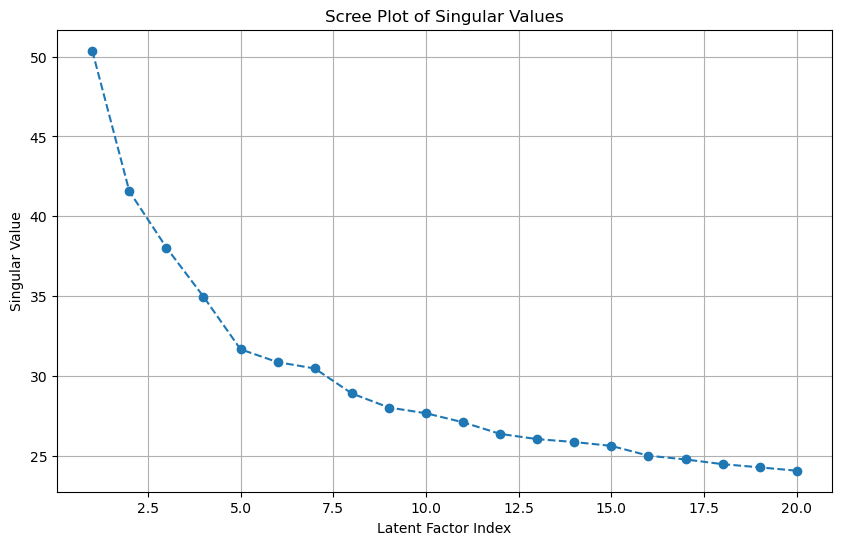

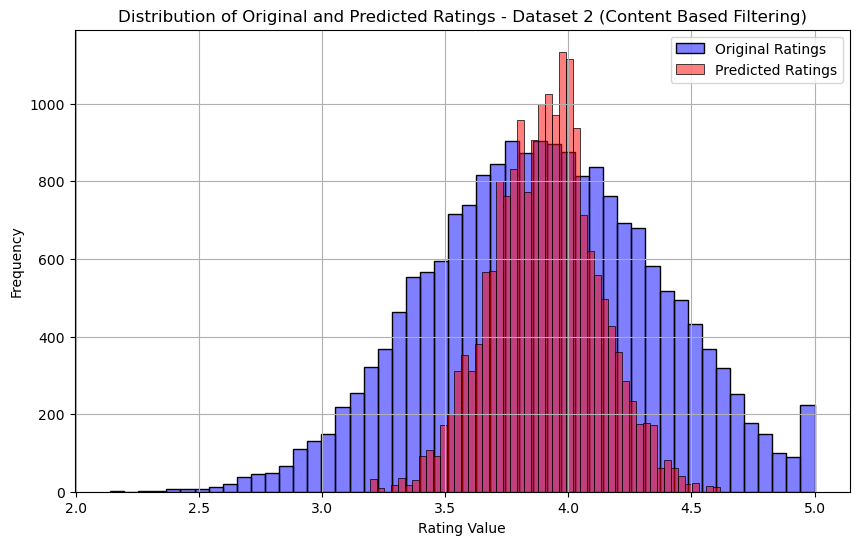

<function matplotlib.pyplot.grid(visible=None, which='major', axis='both', **kwargs)>

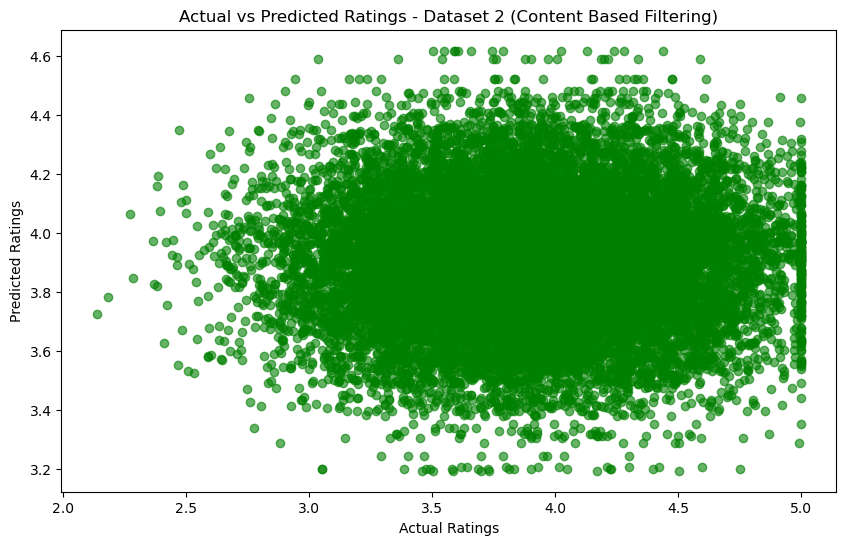

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components + 1), svd.singular_values_, marker='o', linestyle='--')
plt.xlabel('Latent Factor Index')
plt.ylabel('Singular Value')
plt.title('Scree Plot of Singular Values')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(y_test, bins=50, color='blue', alpha=0.5, label='Original Ratings')
sns.histplot(y_pred, bins=50, color='red', alpha=0.5, label='Predicted Ratings')
plt.xlabel('Rating Value')
plt.ylabel('Frequency')
plt.title('Distribution of Original and Predicted Ratings - Dataset 2 (Content Based Filtering)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='green')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs Predicted Ratings - Dataset 2 (Content Based Filtering)')
plt.grid


In [ ]:
def recommend_accommodations(user_input, num_recommendations=5):
    user_account_vector = vectorizer_account.transform([user_input['Account Name']])
    user_owner_vector = vectorizer_owner.transform([user_input['Owner']])

    user_combined_tfidf = hstack([user_account_vector, user_owner_vector])

    user_combined_reduced = svd.transform(user_combined_tfidf)

    user_numerical_features = scaler.transform([[
        user_input['Rating'],
        user_input['Latitude'],
        user_input['Longitude'],
        user_input['Sector'],
        user_input['Total Units']
    ]])

    user_content_features = hstack([csr_matrix(user_combined_reduced), csr_matrix(user_numerical_features)])

    distances, indices = model.kneighbors(user_content_features, n_neighbors=num_recommendations)

    recommended_accommodations = df.iloc[indices[0]]
    return recommended_accommodations[['accommodation_id', 'Account Name', 'Rating', 'Latitude', 'Longitude']]


user_input_example = {
    'Account Name': 'Luxury Hotel',
    'Owner': 'John Doe',
    'Rating': 4.5,
    'Latitude': 53.3498,
    'Longitude': -6.2603,
    'Sector': 2,
    'Total Units': 100
}

# Get recommendations based on user input
recommendations = recommend_accommodations(user_input_example)
print("\nRecommended Accommodations:")
print(recommendations)

